In [1]:
from fastai.vision.all import *
from fastai.optimizer import ranger

In [2]:
path = Path('/home/norbert/Documents/repos/engineerka/data/road')

path_im = path/'unlabeled'
path_lbl = path/'labeled'

In [3]:
lbl_names = get_image_files(path_lbl)
fnames = get_image_files(path_im)

In [4]:
path_lbl

Path('/home/norbert/Documents/repos/engineerka/data/road/labeled')

In [5]:
fnames

(#67) [Path('/home/norbert/Documents/repos/engineerka/data/road/unlabeled/road_300.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/unlabeled/road_52.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/unlabeled/road_405.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/unlabeled/road_16.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/unlabeled/road_12.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/unlabeled/road_294.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/unlabeled/road_61.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/unlabeled/road_42.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/unlabeled/road_22.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/unlabeled/road_375.png')...]

In [6]:
lbl_names[5]

Path('/home/norbert/Documents/repos/engineerka/data/road/labeled/road_294.png')

In [7]:
fn = 'road_32.png'

In [8]:
im = PILImage.create(f'{path_im}/{fn}')
msk = PILMask.create(f'{path_lbl}/road_32.png')

In [9]:
len(np.unique(msk))

2

In [10]:
np.unique(msk)

array([  0, 255], dtype=uint8)

In [11]:
def n_codes(fnames, is_partial=True):
  "Gather the codes from a list of `fnames`"
  vals = set()
  if is_partial:
    random.shuffle(fnames)
    fnames = fnames[:10]
  for fname in fnames:
    msk = np.array(PILMask.create(fname))
    for val in np.unique(msk):
      if val not in vals:
        vals.add(val)
  vals = list(vals)
  p2c = dict()
  for i,val in enumerate(vals):
    p2c[i] = vals[i]
  return p2c

In [12]:
p2c = n_codes(lbl_names)

In [13]:
p2c

{0: 0, 1: 255}

In [14]:
def get_msk(fn, p2c):
  "Grab a mask from a `filename` and adjust the pixels based on `pix2class`"
  fn = path_lbl/f'{fn.stem}{fn.suffix}'
  msk = np.array(PILMask.create(fn))
  mx = np.max(msk)
  for i, val in enumerate(p2c):
    msk[msk==p2c[i]] = val
  return PILMask.create(msk)

In [15]:
codes = ['lane', 'not lane']

name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['not lane']
name2id

{'lane': 0, 'not lane': 1}

In [16]:
def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

In [17]:
opt = ranger

In [18]:
get_y = lambda o: get_msk(o, p2c)

In [19]:
binary = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=get_y,
                   item_tfms=Resize((200, 480)),
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])

In [20]:
def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

In [21]:
path_im

Path('/home/norbert/Documents/repos/engineerka/data/road/unlabeled')

In [22]:
dls = binary.dataloaders(path_im, bs=4)

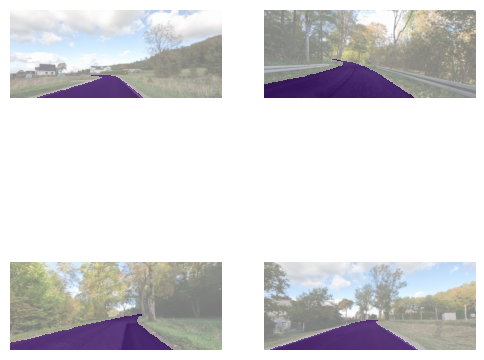

In [23]:
dls.show_batch(cmap='Purples', vmin=0, vmax=1)

In [24]:
learn = unet_learner(dls, resnet34, metrics=acc_camvid, self_attention=True, act_cls=Mish, opt_func=opt)


/home/norbert/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/norbert/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
# fnames2 = get_files(path/'test', extensions=".png")
# dl = learn.dls.test_dl(fnames2)

In [52]:
# learn.lr_find()

RuntimeError: CUDA out of memory. Tried to allocate 304.00 MiB (GPU 0; 7.80 GiB total capacity; 4.38 GiB already allocated; 288.44 MiB free; 5.00 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [25]:
learn.fit(8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.508502,0.259852,0.999993,00:07
1,0.278135,0.101152,0.956409,00:05
2,0.187459,0.059852,0.979446,00:05
3,0.129008,0.031451,0.992680,00:05
4,0.093158,0.042208,0.996816,00:05
5,0.069588,0.025492,0.994979,00:05
6,0.053275,0.031671,0.994729,00:05
7,0.041927,0.026153,0.994791,00:05


In [ ]:
lr = 1e-3
lr

0.001

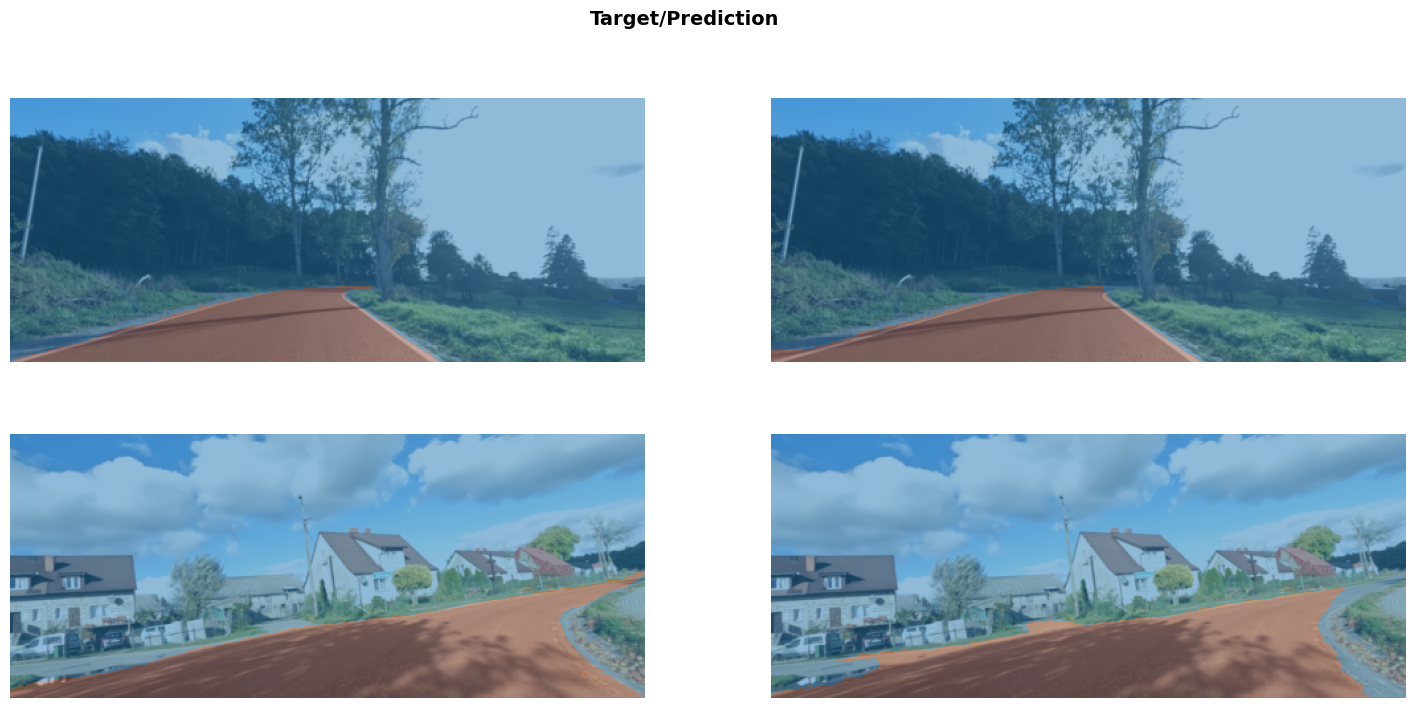

In [26]:
learn.show_results(max_n=2, figsize=(18,8))


In [27]:
learn.save('stage-1')

Path('models/stage-1.pth')